# MedInfo 2019 Practical 3
****
In this practical session you will explore how to validate the prediction models developed in practical 1.

As shown earlier, we can use the 'predict()' function in R to estimate predicted risks from our newly developed CPM.

We will then outline the process of how to use such predicted risks to validate the prediction model. As discussed in the lecture notes, this should be undertaken in new (independent) data. However, we do not have external data to validate our model. For purposes of illustration of the R code, we here test performance within the development dataset. We will call this the 'apparent performance' of the model. Both the calibration and discrimination of the model will be calculated.

It is often the case that we do not have external data, but dont worry there is no need to panic and split our data. As discussed in the lecture, we can perform internal validation. The latter part of this practical will illustrate how to perform bootstrap internal validation.

Due to limited time we will focus only on the model developed in practical 1. The majority of the validation techniques and code still hold for the survival models by evaluating at on eor more timepoints. Where there are differences, they are discused in the text. 


### Lets begin

First lets load the packages we will be using in the practical

In [5]:
library(pROC)
library(DescTools)
library(Hmisc)
library(plyr)
library(boot)
library(MASS)
library(rms)

## Part 1

Begin by loading the data and subset as we have done in previous practicals.

In [6]:
smart <- readRDS("SMARTs_medinfo_P2-4.rds")
smart <- subset(smart, select = c(outcome, TEVENT, EVENT, SEX, AGE, SBP, alcohol, CHOLO, BMIO, DIABETES, CARDIAC, SMOKING, AAA))
smart <- na.omit(smart)
attach(smart)
class(smart)
sapply(smart,class)

[1] "data.frame"

outcome    TEVENT     EVENT       SEX       AGE       SBP   alcohol     CHOLO 
"integer" "numeric" "integer"  "factor" "integer" "integer"  "factor" "numeric" 
     BMIO  DIABETES   CARDIAC   SMOKING       AAA 
"numeric"  "factor"  "factor"  "factor"  "factor"

## Part 2

Fit the multivariable models selected from practical 1

In [7]:
age3_spline <- rcs(AGE,3)

# Fit model selected from practicals 1 and 2
mod_log <- glm(outcome~SEX+SBP+DIABETES+age3_spline,family="binomial",x=TRUE,y=TRUE)
mod_log



Call:  glm(formula = outcome ~ SEX + SBP + DIABETES + age3_spline, family = "binomial", 
    x = TRUE, y = TRUE)

Coefficients:
    (Intercept)          SEXMale              SBP        DIABETES1  
       -3.52344          0.34609          0.00321          0.33952  
 age3_splineAGE  age3_splineAGE'  
       -0.01035          0.05442  

Degrees of Freedom: 3802 Total (i.e. Null);  3797 Residual
Null Deviance:	    1608 
Residual Deviance: 1562 	AIC: 1574

## Part 3 apparent discrimination

Discrimination refers to the ability of a CPM to separate patients who will develop/experiance an outcome from those who will not.  
The C-statistic (concordance) is typically used to assess model discrimination. This is calculated as the concordant pairs of individuals. If we take two individuals, one who experienced the outcome and one who did not, and the individual who had the event was given the higher probability, then this pair of individuals are concordant.
We can also plot the receiver operator characteristic (ROC) curve. *Note - The area under this curve is equivalent to the C-statistic.*

In [8]:
## Calculate apparent discrimination performance

Setting levels: control = 0, case = 1
Setting direction: controls < cases



Call:
roc.formula(formula = outcome ~ pred_prob, ci = TRUE)

Data: pred_prob in 3596 controls (outcome 0) < 207 cases (outcome 1).
Area under the curve: 0.6415
95% CI: 0.6042-0.6787 (DeLong)

Setting levels: control = 0, case = 1
Setting direction: controls < cases


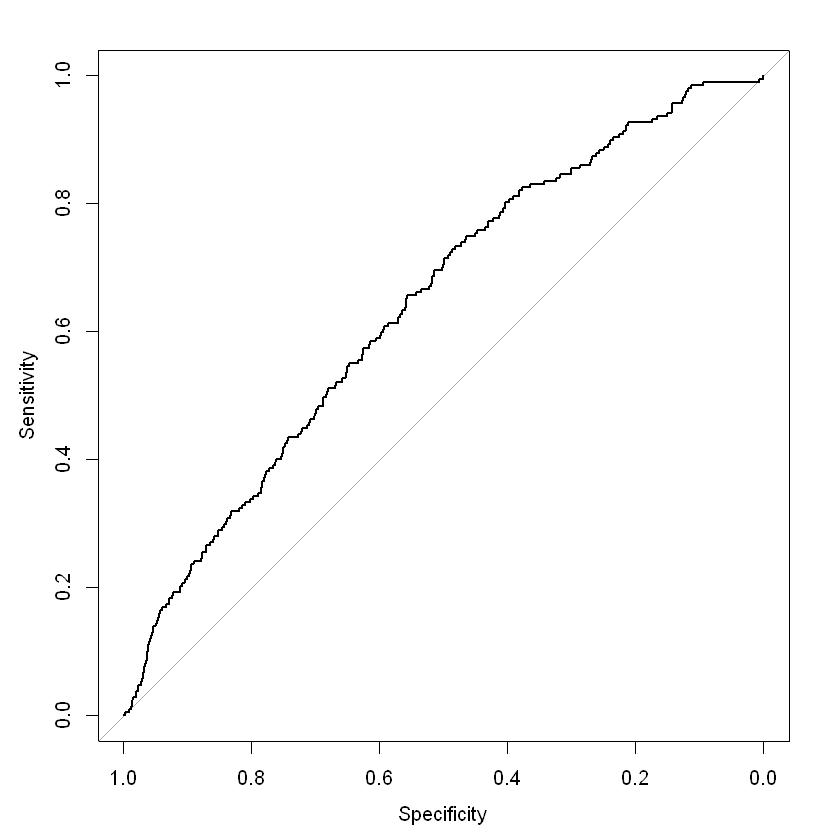

In [9]:
# Obtain the predicted probabilities for each patient
pred_prob <- predict(mod_log,type="response")

# Obtain the c statistic / AUC
c1 <- roc(outcome~pred_prob,ci=TRUE)
c1

# Plot the ROC curve
plot(roc(outcome,pred_prob))

The C-statistic of 0.638 (95% CI, 0.598-0.6783) shows moderate discrimination. A value of 0.5 is equivalent to the probability of tossing a coin and a value of 1 represents perfect discrimination.

The C-statistic can also be calculated for survival models but does not include cencered individuals or individuals with the same event time. The D-statistic is often calculated instead. This was proposed by Royston and Sauerbrei and their paper can be found [here](https://onlinelibrary.wiley.com/doi/abs/10.1002/sim.1621).


In [10]:
#Brier score
BrierScore(mod_log)

[1] 0.05085778

The Brier score is also a measure of performance and ranges from 0 to 0.25, with lower values representing better performance. The brier score of 0.051 indicated good overall performance.

## Part 4 apparent calibration

Lets begin by calculating calibration-in-the-large (CITL). This compares the mean of all prdicted risks with the mean observed risk.The indicates the extent that predictions are systematically too low or too high. 
If CITL > 0, observed proportions are higher than the predicted probabilities.  
If CITL < 0, predicted probabilities are higher than the observed proportions.

We can also use the expected/observed ratio (E/O) by dividing the expected by the observed number of events (or probabilities).  
E/O is related to CITL and when E/O<1, CITL>0. Also, when E/O>1, CITL<0
*Note - When overall prevelence is low, E/O as a ratio can look very large even when differences are smalll.*

In [11]:
# Obtain the linear predictor/PI for each patient
pred_LP <- predict(mod_log,type="link")

# CITL
mod_log_1 <- glm(outcome~offset(pred_LP),family="binomial")
coefficients(mod_log_1)
confint(mod_log_1)

# E/O
prop.table(table(outcome))
O <- prop.table(table(outcome))[2]
E <- mean(pred_prob)
E/O



(Intercept) 
5.07528e-09

Waiting for profiling to be done...


2.5 %     97.5 % 
-0.1440191  0.1382536

outcome
         0          1 
0.94556929 0.05443071 

1 
1

Here, CITL is 0.000000005 (95% CI: -0.14 to 0.14) and the E/O is 1. This shows perfect calibration but remember this is what we would expect here because we are using the data which the model was developed on.

E/O for survival models we use expected and observed event probabilities rather than the number of events. This can be calculated to one or more time points. Thereofre the expected/observed ratio at 2 years (24 months) is,  
$$E/O(t) = \frac{1-S_{exp}(t)}{1-S_{obs}(t)}$$



An alternative (more formal) way of testing calibraiton is by estimating the so-called calibration intercept and slope. These are obtained by fitting a logistic regression model to the observed outcomes and using the linear predictor of the model as the only covariate. A perfectly calibrated CPM would have a calibration intercept equal to 0 and a slope equal to 1. A intercept > 0 implies the model systematically under-predicts risk (and vice versa), while a calibration slope < 1 indicates the model is overfitted (too extreme risk predictions).

This can also be done for survival models for specific times, using similar methods to the E/O to obtain observed and expected probabilities within risk groups.

In [12]:
mod_log_2 <- glm(outcome~pred_LP,family="binomial",x=TRUE,y=TRUE)
coefficients(mod_log_2)
confint(mod_log_2)

(Intercept)     pred_LP 
1.66204e-13 1.00000e+00

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),-0.8082760,0.7860995
pred_LP,0.7141317,1.2835378


As expected, the 95% confidence interval for the calibration intercept includes 0 and that for the calibration slope includes 1. This gives evidence that the model is well calibrated. However, as above, in reality we would need to test this on new data, to account for in-sample optimism.

For survival models you can obtain the the calibration slope by fitting a cox model to the LP as the only predictor. For example, *coxph(surv(TEVENT, EVENT)~pred_LP,x=TRUE,y=TRUE)*

Another way to assess calibration of a CPM is a so-called calibration plot, which we make by dividing the data into several (usually ten) equally sized groups based on the ordered probabilities, and calculating the observed and expected number of events in each group. One way of doing this is using the code below:

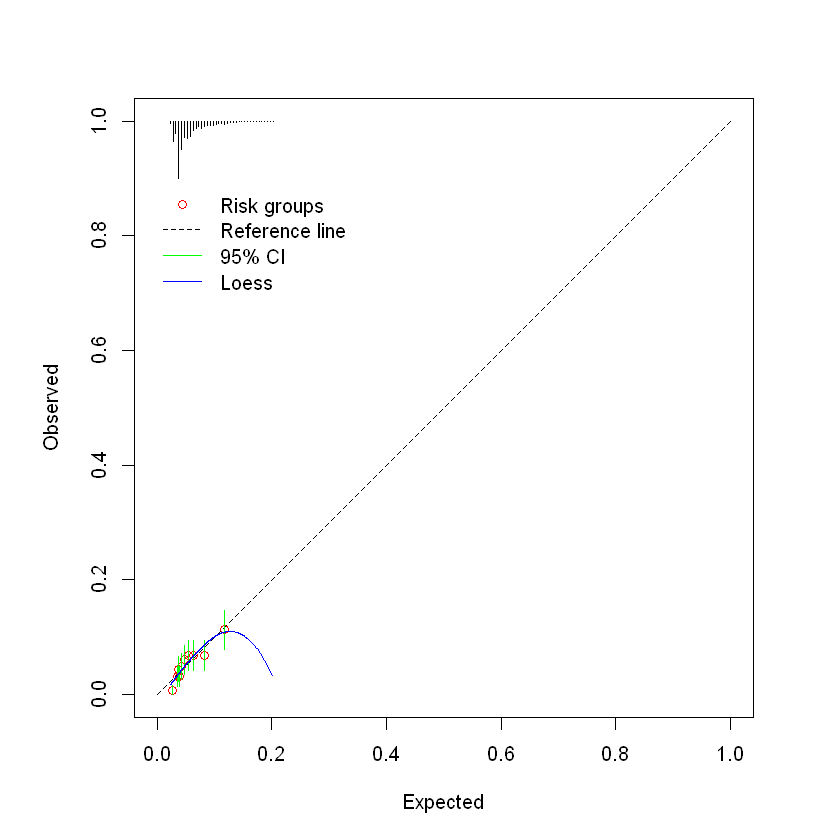

In [13]:
# Visual assessment of calibration by risk groups

# create 10 risk groups
groups <- cut(pred_prob,breaks=quantile(pred_prob, prob = c(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0)),labels=c(1:10),include.lowest=TRUE)
 
# average the observed and expected probabilities of patients in each risk group 
gpdata <- cbind(smart,groups,pred_prob)
obs <- (ddply(gpdata,~groups,summarise,mean=mean(as.numeric(outcome)))[,2])
exp <- ddply(gpdata,~groups,summarise,mean=mean(pred_prob))
obsn <- table(outcome,groups)[1,] 

# CIs for scatter points
lci = pmax(0,(obs - (1.96*(((obs*(1-obs))/obsn)^.5))))
uci = pmin(1,(obs + (1.96*(((obs*(1-obs))/obsn)^.5))))

# graph a simple calibration plot over 10 risk groups
par(pty="s")
plot(obs~exp[,2],xlim=c(0,1),ylim=c(0,1),col="red",ylab="Observed",xlab="Expected")
lines(c(0,1),c(0,1),lty=2)
for(i in 1:10){
lines(c(exp[i,2],exp[i,2]),c(lci[i],uci[i]),col="green")
}
h <- hist(pred_prob, breaks=50, plot=FALSE)
for(i in 1:length(h$mids)){
  lines(c(h$mids[i],h$mids[i]),c(rep(1,length(h$mids))[i],1-((h$counts[i]/max(h$counts))/10)))
}

# Add a loess smoother to the plot
obs_all <- predict(loess((as.numeric(outcome))~pred_prob,span=1))
lines_data <- data.frame(pred_prob,obs_all)
lines_data2 <- lines_data[order(pred_prob),] 
lines(lines_data2[,1],lines_data2[,2],col="blue")
legend(0.0,0.9,c("Risk groups","Reference line","95% CI","Loess"),col=c("red","black","green","blue"),lty=c(0,2,1,1),pch=c(1,NA,NA,NA),bty="n")


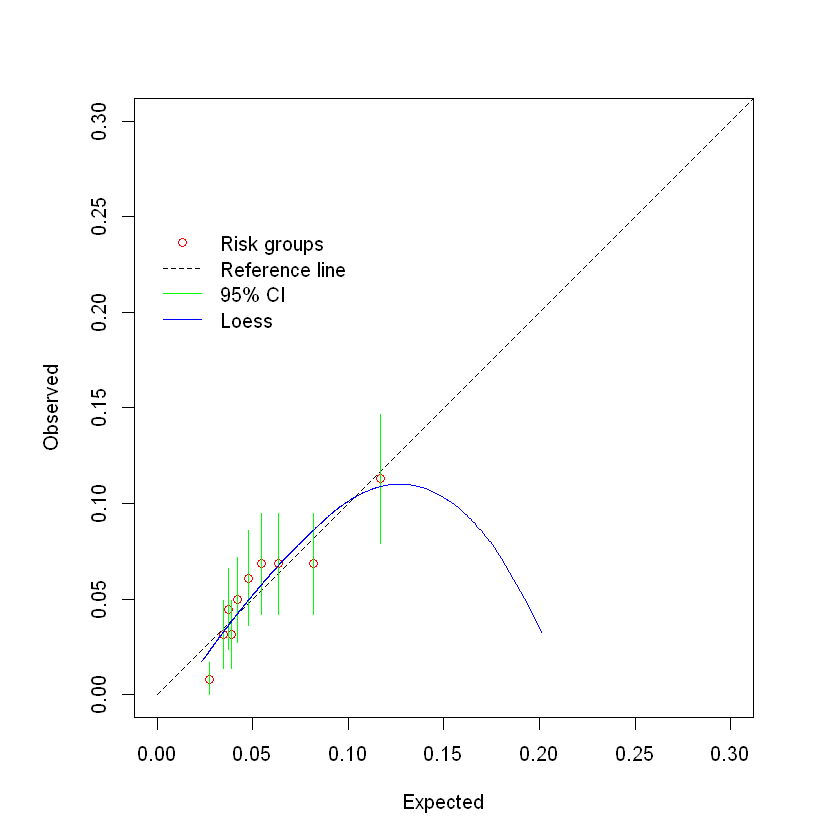

In [14]:
par(pty="s")
plot(obs~exp[,2],xlim=c(0,.3),ylim=c(0,.3),col="red",ylab="Observed",xlab="Expected")
lines(c(0,1),c(0,1),lty=2)
for(i in 1:10){
lines(c(exp[i,2],exp[i,2]),c(lci[i],uci[i]),col="green")
}
h <- hist(pred_prob, breaks=50, plot=FALSE)
for(i in 1:length(h$mids)){
  lines(c(h$mids[i],h$mids[i]),c(rep(1,length(h$mids))[i],1-((h$counts[i]/max(h$counts))/10)))
}

# Add a loess smoother to the plot
obs_all <- predict(loess((as.numeric(outcome))~pred_prob,span=1))
lines_data <- data.frame(pred_prob,obs_all)
lines_data2 <- lines_data[order(pred_prob),] 
lines(lines_data2[,1],lines_data2[,2],col="blue")
legend(0.0,0.25,c("Risk groups","Reference line","95% CI","Loess"),col=c("red","black","green","blue"),lty=c(0,2,1,1),pch=c(1,NA,NA,NA),bty="n")


As expected, all of the points lie along the y=x line, showing that there is good agreement between the observed and expected event rates (i.e. good calibration). 

These results show that the CPM is well calibrated and has moderate discrimination. However, these performance estimates are misleading because they are based on the data for which the CPM was derived and are therefore subject to in-sample optimism.  

This optimism can be adjusted for by bootstrapped validation. This is the prefered method for internal validation of a prediction model.

## Part 5 bootstrap validation

In [15]:

# You can obtain c-statistic and c-slope directly from Harrell's "validate" programme within 'rms'.
mod1 <- lrm(outcome~SEX+SBP+DIABETES+age3_spline,x=TRUE,y=TRUE)
set.seed(231398)
boot_1 <- validate(mod1,method="boot",B=50)
boot_1

# Note that this gives Dxy rather than c, however Dxy = 2*(c-0.5), i.e. c=(Dxy/2)+0.5
(boot_1[1,1]+1)/2
(boot_1[1,5]+1)/2


          index.orig training    test optimism index.corrected  n
Dxy           0.2829   0.2875  0.2616   0.0259          0.2571 50
R2            0.0343   0.0389  0.0314   0.0074          0.0268 50
Intercept     0.0000   0.0000 -0.1990   0.1990         -0.1990 50
Slope         1.0000   1.0000  0.9252   0.0748          0.9252 50
Emax          0.0000   0.0000  0.0579   0.0579          0.0579 50
D             0.0116   0.0132  0.0106   0.0025          0.0091 50
U            -0.0005  -0.0005  0.0002  -0.0007          0.0002 50
Q             0.0122   0.0137  0.0104   0.0033          0.0089 50
B             0.0509   0.0505  0.0510  -0.0005          0.0513 50
g             0.4911   0.5248  0.4777   0.0472          0.4440 50
gp            0.0269   0.0282  0.0258   0.0024          0.0245 50

[1] 0.6414716

[1] 0.6285341

In [16]:
## To get bootstrapped answers for CITL, c-statistic & c-slope it's a more manual approach:
manual_boot <- function(data,samples){
  results <- matrix(nrow = samples,ncol = 6)
  set.seed(231398)
  for (i in 1:samples) {
    samp_index <- sample(1:nrow(data), nrow(data), rep=TRUE) # create a sampling index vector
   
    bs_samp <- data[samp_index,] # index the orignal dataset using the sampling vector to give the bs sample
    model <- glm(outcome~SEX+age3_spline + DIABETES,family=binomial, data=bs_samp)  # Fit model to the bootstrap sample
    pr_bs <- predict(model,type="response") # predict probabilities from the bootstrap model in the bs sample
    lp_bs <- predict(model) # predict lp from the bootstrap model in the bs sample
    
    pr_test <- predict(model,type="response",newdata = data) # predict probabilities from the bootstrap model in the original sample
    lp_test <- predict(model, newdata = data) # predict lp from the bootstrap model in the original sample
    
    # calculate the apparent performance of the bootstrap model in the bs sample
    app_cstat_model <- roc(outcome~pr_bs,data=bs_samp)
    results[i,1] <- app_cstat_model$auc
    app_citl_model <- glm(outcome ~ offset(lp_bs),family=binomial, data=bs_samp)
    results[i,2] <- summary(app_citl_model)$coefficients[1,1]
    app_cslope_model <- glm(outcome ~ lp_bs,family=binomial(link='logit'), data=bs_samp)
    results[i,3] <- summary(app_cslope_model)$coefficients[2,1]
    
    # calculate the test performance of the bootstrap model in the original sample
    test_cstat_model <- roc(outcome~pr_test,data=data)
    results[i,4] <- test_cstat_model$auc
    test_citl_model <- glm(outcome ~ offset(lp_test),family=binomial, data=data)
    results[i,5] <- summary(test_citl_model)$coefficients[1,1]
    test_cslope_model <- glm(outcome ~ lp_test,family=binomial, data=data)
    results[i,6] <- summary(test_cslope_model)$coefficients[2,1]
 
    print(i)
  }
  results2 <- as.data.frame(results)
  colnames(results2) <- c("app_c_stat","app_citl","app_c_slope","test_c_stat","test_citl","test_c_slope")
  return(results2)
}
boot_results <- manual_boot(smart,50)


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 2


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 3


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 4


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 5


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 6


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 7


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 8


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 9


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 10


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 11


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 12


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 13


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 14


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 15


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 16


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 17


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 18


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 19


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 20


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 21


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 22


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 23


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 24


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 25


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 26


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 27


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 28


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 29


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 30


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 31


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 32


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 33


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 34


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 35


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 36


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 37


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 38


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 39


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 40


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 41


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 42


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 43


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 44


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 45


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 46


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 47


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases


[1] 48


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 49


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 50


The optimisum adjusted statistics can then be obtained.  
We can also calculate the optimism in the validation statistics from validating in the development data.

In [17]:
# optimism adjusted statistics
c1$auc - (mean(boot_results$app_c_stat)-mean(boot_results$test_c_stat)) # c-stat
mod_log_1$coef - (mean(boot_results$app_citl)-mean(boot_results$test_citl)) # citl
mod_log_2$coef[2]- (mean(boot_results$app_c_slope)-mean(boot_results$test_c_slope)) # c-slope

#optimism on its own
mean(boot_results$app_c_stat)-mean(boot_results$test_c_stat)
mean(boot_results$app_citl)-mean(boot_results$test_citl)
mean(boot_results$app_c_slope)-mean(boot_results$test_c_slope)

[1] 0.6206276

(Intercept) 
0.008793745

pred_LP 
0.8183995

[1] 0.02084402

[1] -0.00879374

[1] 0.1816005

In [18]:
# optimism adjusted statistics
c1$auc - (mean(boot_results$app_c_stat)-mean(boot_results$test_c_stat)) # c-stat
mod_log_1$coef - (mean(boot_results$app_citl)-mean(boot_results$test_citl)) # citl
mod_log_2$coef[2]- (mean(boot_results$app_c_slope)-mean(boot_results$test_c_slope)) # c-slope

#optimism on its own
mean(boot_results$app_c_stat)-mean(boot_results$test_c_stat)
mean(boot_results$app_citl)-mean(boot_results$test_citl)
mean(boot_results$app_c_slope)-mean(boot_results$test_c_slope)

[1] 0.6206276

(Intercept) 
0.008793745

pred_LP 
0.8183995

[1] 0.02084402

[1] -0.00879374

[1] 0.1816005

In [19]:
## To get bootstrapped answers for CITL, c-statistic & c-slope it's a more manual approach:
k10 <- qchisq(0.10,1,lower.tail=FALSE)

manual_boot_bw <- function(data,samples){
  results <- matrix(nrow = samples,ncol = 6)
  set.seed(231398)
  for (i in 1:samples) {
    samp_index <- sample(1:nrow(data), nrow(data), rep=TRUE) # create a sampling index vector
   
    bs_samp <- data[samp_index,] # index the orignal dataset using the sampling vector to give the bs sample
    model <- glm(outcome~SEX+age3_spline + SBP + alcohol + CHOLO + BMIO + DIABETES + CARDIAC + SMOKING + AAA,family=binomial, data=bs_samp)  # Fit model to the bootstrap sample
    backward_model <- stepAIC(model,k=k10,direction="backward",trace=FALSE)
    pr_bs <- predict(backward_model,type="response") # predict probabilities from the bootstrap model in the bs sample
    lp_bs <- predict(backward_model) # predict lp from the bootstrap model in the bs sample
    
    pr_test <- predict(model,type="response",newdata = data) # predict probabilities from the bootstrap model in the original sample
    lp_test <- predict(model, newdata = data) # predict lp from the bootstrap model in the original sample
    
    # calculate the apparent performance of the bootstrap model in the bs sample
    app_cstat_model <- roc(outcome~pr_bs,data=bs_samp)
    results[i,1] <- app_cstat_model$auc
    app_citl_model <- glm(outcome ~ offset(lp_bs),family=binomial, data=bs_samp)
    results[i,2] <- summary(app_citl_model)$coefficients[1,1]
    app_cslope_model <- glm(outcome ~ lp_bs,family=binomial(link='logit'), data=bs_samp)
    results[i,3] <- summary(app_cslope_model)$coefficients[2,1]
    
    # calculate the test performance of the bootstrap model in the original sample
    test_cstat_model <- roc(outcome~pr_test,data=data)
    results[i,4] <- test_cstat_model$auc
    test_citl_model <- glm(outcome ~ offset(lp_test),family=binomial, data=data)
    results[i,5] <- summary(test_citl_model)$coefficients[1,1]
    test_cslope_model <- glm(outcome ~ lp_test,family=binomial, data=data)
    results[i,6] <- summary(test_cslope_model)$coefficients[2,1]
 
    print(i)
  }
  results2 <- as.data.frame(results)
  colnames(results2) <- c("app_c_stat","app_citl","app_c_slope","test_c_stat","test_citl","test_c_slope")
  return(results2)
}
boot_results_bw <- manual_boot_bw(smart,50)


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 2


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 3


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 4


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 5


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 6


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 7


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 8


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 9


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 10


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 11


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 12


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 13


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 14


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 15


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 16


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 17


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 18


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 19


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 20


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 21


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 22


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 23


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 24


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 25


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 26


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 27


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 28


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 29


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 30


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 31


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 32


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 33


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 34


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 35


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 36


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 37


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 38


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 39


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 40


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 41


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 42


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 43


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 44


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 45


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 46


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 47


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 48


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 49


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] 50


In [20]:
# optimism adjusted statistics
c1$auc - (mean(boot_results_bw$app_c_stat)-mean(boot_results_bw$test_c_stat)) # c-stat
mod_log_1$coef - (mean(boot_results_bw$app_citl)-mean(boot_results_bw$test_citl)) # citl
mod_log_2$coef[2]- (mean(boot_results_bw$app_c_slope)-mean(boot_results_bw$test_c_slope)) # c-slope

#optimism on its own
mean(boot_results_bw$app_c_stat)-mean(boot_results_bw$test_c_stat)
mean(boot_results_bw$app_citl)-mean(boot_results_bw$test_citl)
mean(boot_results_bw$app_c_slope)-mean(boot_results_bw$test_c_slope)

[1] 0.619822

(Intercept) 
0.008651033

pred_LP 
0.7965384

[1] 0.02164956

[1] -0.008651028

[1] 0.2034616